In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlopen #url의 html 을 가져 오기 위한 패키지
from bs4 import BeautifulSoup  #크롤링 필수 패키지 설치하려면 cmd창에서 pip install bs4
import os
import re
from selenium import webdriver
from bs4 import BeautifulSoup #크롤링 도구
from selenium.webdriver.common.keys import Keys
import time
from tqdm import tqdm
import os
import re
import time
import json
import datetime
from konlpy.tag import Okt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pylab as pl
import statsmodels.api as sm
from sklearn.cluster import DBSCAN
import sklearn as skl
import sklearn.model_selection
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from ckonlpy.tag import Twitter
import string
import glob
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
import warnings
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib import font_manager, rc
from ckonlpy.tag import Postprocessor
#글씨체
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/H2HDRM.TTF').get_name()
rc('font', family=font_name)
#모델 데이터 불러오기
data50 = pd.read_excel('C:/Users/USER/Desktop/1~8newsurl/data0923.xlsx', index_col=0)#데이터 불러오기
embedding_model = KeyedVectors.load_word2vec_format('C:/Users/USER/Desktop/1~8newsurl/w2v0923') # 모델 로드
data50['words'] = [i.replace("'", "").replace('[', '').replace(']', '').replace(' ', '').split(',') for i in
          list(data50['words'])]  # words가 텍스트 형식으로 되어 있을 경우

#3글자 부터 밎 주요 2단어 포함
data = data50.reset_index(drop=True)
words = list(data['words'])
for k in range(len(words)):
    words[k] = [i for i in words[k] if len(i) > 2 or i in ['배달','택배','고용','취업','실업','채용','구직','청년','유통','해고']]  # 두글자 이하 제외
data['words'] = words
data['words'][:5]
del words; del k; del data50
#data.to_excel('C:/Users/USER/Desktop/1~8newsurl/data0928.xlsx')
def word_score2(word,allnum,num):
    a =[]
    for j in range(len(data)):
        if word in data['words'][j]:
            a.append(data.iloc[j])
    a = pd.DataFrame(a).reset_index(drop=True)
    a['cw'] = word
    a = a[['cw','date','title','text','category','url','words']]
    aa = a['words']
    #a2 = [i.replace("'","").replace('[','').replace(']','').replace(' ','').split(',') for i in aa] #words가 텍스트 형식으로 되어 있을 경우
    a2 = a['words'] #words가 list로 되어 있을 경우
    #score구하기
    avg_dist = []
    dist = []
    dist_dist = []
    for i in tqdm(range(len(a2))):
        for k in a2[i]:
            try:
                 # 비교하여 similarity 구하기
                dist_dist.append(embedding_model.similarity(word, k))
            except:
                dist_dist.append(0)
            dist2 = np.array(dist_dist)
            dist.append(sum(dist2))
            dist_dist = []
        if len(dist) > 1000:
            dist = sorted(dist, reverse=True)[:1000]
        avg_dist.append(np.mean(dist))
        dist = []
    avg_dist
    a['score'] = avg_dist
    #이상치 경계 구하기
    q1 = np.percentile(a['score'], 25)
    q3 = np.percentile(a['score'],75)
    iqr = q3-q1
    outlier = q1 -  1.5 * iqr
    print(outlier, ' 값 이하 제거 필요')
    j=0
    for k in a['score']:
        if k < outlier:
            j +=1
    print('이상치 ', j, '개 있음')
    plt.subplot(int('1'+ str(allnum) + str(num))) #박스플랏 바꿔야함
    sns.boxplot( data = a['score'])
    plt.title(word)
    plt.axis('off')
    plt.text(0.43,q1,round(q1, 2),fontsize = 9)
    plt.text(0.43,np.median(a['score']),round(np.median(a['score']),2), fontsize = 9)
    plt.text(0.43,q3,round(q3,2),fontsize = 9)
    plt.text(0.4,outlier,round(outlier,2),fontsize = 9)
    plt.show()
    return a

In [2]:
def cut_row(word):
    # word단어가 포함된 기사만 가져오기
    a =[]
    for j in range(len(data)):
        if word in data['words'][j]:
            a.append(data.iloc[j])
    a = pd.DataFrame(a).reset_index(drop=True)
    a['cw'] = word
    a = a[['cw','date','title','text','category','url','words']]
    a2 = a['words']
    #score 구하기
    avg_dist = []
    dist = []
    dist_dist = []
    for i in tqdm(range(len(a2))):
        for k in a2[i]:
            try:
                 # 비교하여 similarity 구하기
                dist_dist.append(embedding_model.similarity(word, k))
            except:
                dist_dist.append(0)
            dist2 = np.array(dist_dist)
            dist.append(sum(dist2))
            dist_dist = []
        if len(dist) > 1000:
            dist = sorted(dist, reverse=True)[:1000]
        avg_dist.append(np.mean(dist))
        dist = []
    a['score'] = avg_dist

    #이상치 구하기
    q1 = np.percentile(a['score'], 25)
    q3 = np.percentile(a['score'],75)
    iqr = q3-q1
    outlier = q1 -  1.5 * iqr
    print(outlier, ' 값 이하 제거 필요')
    j=0
    for k in a['score']:
        if k < outlier:
            j +=1
    print('이상치 ', j, '개 제거')
    return_data = a[a['score'] > outlier]
    return return_data

In [4]:
asd = cut_row('소상공인')

100%|████████████████████████████████████████████████████████████████████████████| 3282/3282 [00:03<00:00, 1039.89it/s]

-0.061005545782359366  값 이하 제거 필요
이상치  1 개 제거


In [7]:
asd1 = cut_row('소상공인')
asd2 = cut_row('취약계층')
asd3 = cut_row('의료진')
asd4 = cut_row('화상회의')
asd5 = cut_row('실업')
asd = pd.concat([asd1,asd2,asd3,asd4,asd5])
len(asd)

100%|████████████████████████████████████████████████████████████████████████████| 3282/3282 [00:03<00:00, 1060.16it/s]


-0.061005545782359366  값 이하 제거 필요
이상치  1 개 제거


100%|████████████████████████████████████████████████████████████████████████████| 1927/1927 [00:01<00:00, 1034.78it/s]


-0.04687500994398512  값 이하 제거 필요
이상치  3 개 제거


100%|████████████████████████████████████████████████████████████████████████████| 2755/2755 [00:02<00:00, 1025.74it/s]


-0.03991921145712016  값 이하 제거 필요
이상치  12 개 제거


100%|███████████████████████████████████████████████████████████████████████████████| 667/667 [00:00<00:00, 912.38it/s]


-0.04621121730868663  값 이하 제거 필요
이상치  2 개 제거


100%|███████████████████████████████████████████████████████████████████████████████| 673/673 [00:00<00:00, 731.86it/s]

-0.025616021593259125  값 이하 제거 필요
이상치  1 개 제거


9285

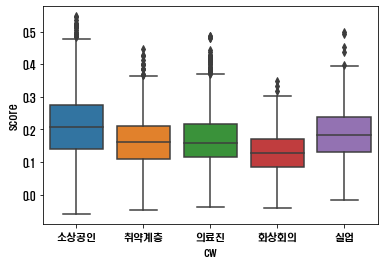

In [9]:
sns.boxplot(x = 'cw', y = 'score', data = asd)
plt.show()